## Imports y dependencias

In [1]:
import os
from google.cloud import bigquery, storage
import google.auth

import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.plots.initjs()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

import time
from datetime import timedelta
 
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
 
#nuevo
# Make clients.
bqclient = bigquery.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))
bqstorageclient = storage.Client(project=os.environ.get("CLOUD_ML_PROJECT_ID"))

## Visionado y estudio de tablas

### Tabla **ALTAS** (electricidad)

In [2]:
consulta_tablon_train = f"""
select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.altas_con_id`
"""
print (consulta_tablon_train)
#bqclient.query(consulta_tablon_train).result()
## Todas las llamadas a analizar TOTAL!!
df_altas = (
    bqclient.query(consulta_tablon_train)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
df_altas


select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.altas_con_id`



,fecha,signup_date_altas,dwh_customer_key,customer_id,product,canal
0,2025-05-07,NaT,47000155,22124727,Electricidad,None
1,2025-04-02,2025-03-31,47898705,25911940,Electricidad,None
2,2025-03-31,NaT,47898705,25911940,Electricidad,None
3,2025-03-31,NaT,47898705,25911940,Gas,None
4,2025-04-02,2025-03-31,47898705,25911940,Gas,None
...,...,...,...,...,...,...
22626,2025-04-25,NaT,62910835,53054496,Electricidad,TIENDAS
22627,2025-04-30,NaT,62939251,53056645,Electricidad,TIENDAS
22628,2025-05-03,2025-04-30,62939251,53056645,Electricidad,TIENDAS
22629,2025-04-30,NaT,62938957,53056704,Electricidad,TIENDAS


In [3]:
df_altas['product'].unique()

array(['Electricidad', 'Gas', 'SVE', 'SVG'], dtype=object)

In [4]:
df_altas['canal'].unique()

array([None, 'CANCELACIONES', 'CARTERA OUTBOUND', 'CUSTOMER CARE',
       'DIGITAL', 'DISTRIBUCION ONLINE', 'OTROS', 'SERVICES2SALES',
       'STANDS', 'TIENDAS'], dtype=object)

In [5]:
#transformar ese df a solo Electricidad
df_altas_electricidad = df_altas[df_altas["product"]=="Electricidad"]

In [6]:
df_altas_electricidad = pl.from_pandas(df_altas_electricidad)
df_altas_electricidad

fecha,signup_date_altas,dwh_customer_key,customer_id,product,canal
date,date,str,str,str,str
2025-05-07,null,"""47000155""","""22124727""","""Electricidad""",null
2025-04-02,2025-03-31,"""47898705""","""25911940""","""Electricidad""",null
2025-03-31,null,"""47898705""","""25911940""","""Electricidad""",null
2025-05-07,null,"""41979466""","""39345505""","""Electricidad""",null
2025-04-11,2025-04-09,"""48576049""","""44698488""","""Electricidad""",null
…,…,…,…,…,…
2025-04-25,null,"""62910835""","""53054496""","""Electricidad""","""TIENDAS"""
2025-04-30,null,"""62939251""","""53056645""","""Electricidad""","""TIENDAS"""
2025-05-03,2025-04-30,"""62939251""","""53056645""","""Electricidad""","""TIENDAS"""


### Tabla **NPTB**

In [7]:
consulta_tablon_train = f"""
select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.nptb_jzz`
"""
print (consulta_tablon_train)
#bqclient.query(consulta_tablon_train).result()
## Todas las llamadas a analizar TOTAL!!
st=time.time()
df_nptb = (
    bqclient.query(consulta_tablon_train)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
print(f"Tiempo de fetch: {timedelta(seconds=time.time() - st)}")
df_nptb.rename(columns={"uni_id_cliente": "id_cliente"}, inplace=True)
df_nptb = pl.from_pandas(df_nptb)


select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.nptb_jzz`

Tiempo de fetch: 0:04:18.921576


In [8]:
print(df_nptb.shape)
df_nptb.head(10)

(5471905, 209)


id_cliente,uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,uni_min_cp_importe_fin_linea,uni_min_cp_dias_fin_linea,uni_comp_lineas_oo,…,con_num_paq_naveg_mov_lin_dm7,con_num_fallos_sms_env_mov_lin_dm7,con_num_fallos_sms_rec_mov_lin_dm7,con_num_fallos_est_llam_mov_lin_dm7,con_num_fallos_sms_mov_lin_dm7,con_min_retrans_naveg_mov_lin_dm7,con_min_ratio_llam_caidas_mov_lin_dm7,con_max_ratio_llam_caidas_mov_lin_dm7,con_min_ratio_llam_no_estab_mov_lin_dm7,con_max_ratio_llam_no_estab_mov_lin_dm7,con_min_dist_celda_home_mov_lin_dm7,con_max_dist_celda_home_mov_lin_dm7,con_num_llam_estab_mov_lin_dm7,con_num_sms_env_mov_lin_dm7,crm_eventos_in_prob_cond_avg_sdb_30d,crm_eventos_in_max_avg_sdb_30d,crm_eventos_in_min_avg_sdb_30d,crm_eventos_in_sum_pond_avg_sdb_30d,velocidad_fijo,days_since_upgrade_ftth_premium,days_since_upgrade_ftth_no_premium,conn_fix_flag_config_defec_naveg_fij_dm7_cli,conn_fix_num_alarm_ont_fij_dm7_cli,conn_fix_num_alarm_no_soluc_ont_fij_dm7_cli,conn_fix_num_disp_naveg_fij_dm7_cli,conn_fix_num_disp_mc_naveg_fij_dm7_cli,conn_fix_num_cortes_optic_naveg_fij_dm7_cli,conn_fix_num_repetidores_naveg_fij_dm7_cli,conn_fix_avg_potenc_ont_rec_fij_dm7_cli,conn_fix_avg_potenc_ont_trans_fij_dm7_cli,conn_fix_avg_potenc_olt_rec_fij_dm7_cli,conn_fix_avg_potenc_olt_trans_fij_dm7_cli,conn_fix_avg_rssi_24_naveg_fij_dm7_cli,conn_fix_avg_rssi_5_naveg_fij_dm7_cli,conn_fix_oe_estado_ont_fij_dm7_cli,conn_fix_oe_alarm_ont_fij_dm7_cli,ndt_data_date
i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,…,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,str
20929604,1,1,0,"""RESIDENCIAL""",1,4,143,17,187,55,175.922195,0.61,453,0.62,0,0,0,8631,0,0,0,0,297,1006.349976,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,0,…,3089728,1,18,0,19,0.0,0.0,0.0,0.0,0.0,0.3589,8.1147,164,1,-98765.0,-99.0,-99.0,-99.0,300,9999,906,0,0,0,1,0,0,0,-16.715,1.6145,-21.6668,6.491,-61.75,-68.75,1,0,"""20250301"""
27408233,1,1,0,"""RESIDENCIAL""",1,1,121,42,121,42,0.0,0.0,-3339,0.0,0,0,0,11138,0,0,0,0,31,24.23,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,1,…,5651973,0,6,0,6,0.0027,0.0,0.0,0.0,0.0,3.8698,3.8698,50,0,-98765.0,-99.0,-99.0,-99.0,1024,1666,9999,0,1,0,0,0,1,0,-24.7815,2.5855,-27.2495,3.72,0.0,0.0,1,2,"""20250401"""
20055645,1,1,1,"""RESIDENCIAL""",1,4,148,42,224,112,0.0,0.0,-1710,0.0,0,0,0,109518,0,0,0,0,29,100.870003,0,0.0,0.0,1000,0,0,36,36,0,0.0,-9999,3,…,51650777,0,14,0,14,0.0017,0.0,0.0,0.0,0.0,4.4109,19.8743,23,0,0.055957,0.055957,0.055957,0.005087,1024,9999,9999,0,0,0,5,3,0,0,0.0,0.0,0.0,0.0,-39.299999,-73.1343,0,0,"""20250401"""
49476142,1,1,0,"""RESIDENCIAL""",1,4,26,1,26,65,0.0,0.0,-69,0.0,0,0,0,47755,0,0,0,1659,104,362.470001,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,0,…,23407795,0,5,1,5,0.0,0.0,0.0,0.0,0.2,3.1137,8.9365,77,0,0.579377,0.126582,0.028131,0.054853,600,477,9999,0,0,0,1,0,0,0,-26.0495,2.404,-28.591499,3.758,-45.25,-74.333298,1,0,"""20250401"""
42287632,1,1,0,"""RESIDENCIAL""",1,2,51,40,51,40,239.125,0.63,480,0.66,0,0,0,2887,0,0,0,2887,59,293.230011,0,0.0,0.0,1000,0,0,0,0,0,0.0,-1207,0,…,1161334,0,4,0,4,0.0,0.0,0.0,0.0,0.0,0.8774,0.8774,87,0,-98765.0,-99.0,-99.0,-99.0,300,9999,1234,0,0,0,1,0,0,0,0.0,0.0,0.0,0.

### Tabla **CHURN**

In [9]:
consulta_tablon_train = f"""
select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.churn_jzz`
"""
print (consulta_tablon_train)
#bqclient.query(consulta_tablon_train).result()
## Todas las llamadas a analizar TOTAL!!
st=time.time()
df_churn = (
    bqclient.query(consulta_tablon_train)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
print(f"Tiempo de fetch: {timedelta(seconds=time.time() - st)}")
df_churn.rename(columns={"customer_id": "id_cliente"}, inplace=True)
df_churn = pl.from_pandas(df_churn)


select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.churn_jzz`

Tiempo de fetch: 0:02:30.292800


In [10]:
print(df_churn.shape)
df_churn.head(10)

(5621182, 170)


id_cliente,num_sms_in_low_dm30,dias_desde_ultimo_sms_in_low,num_contactos_distintos_sms_in_low_dm30,crm_eventos_in_num_eventos,crm_eventos_in_dias_ult_evento,crm_eventos_in_max_avg_sdb_30d,crm_eventos_in_min_avg_sdb_30d,crm_eventos_in_sum_pond_avg_sdb_30d,crm_eventos_in_prob_cond_avg_sdb_30d,ratio_precio_min_inc_mov_cli,ratio_precio_min_inc_fij_cli,ratio_precio_min_cos_mov_cli,ratio_precio_mb_mov_cli,billing_shock_3m_cli,billing_shock_6m_cli,num_eventos_crm_dm7,flag_pporta_crm_dm7,flag_ppaten_crm_dm7,flag_ppfide_crm_dm7,flag_ppotro_crm_dm7,num_eventos_remedy,num_eventos_abier_remedy,dias_ult_evento_remedy,max_avg_sdb_30d_remedy,min_avg_sdb_30d_remedy,sum_pond_avg_sdb_30d_remedy,prob_cond_avg_sdb_30d_remedy,dias_sig_cierre_central_cli,num_sessions_dns_dm30,total_duration_dns_dm30,max_duration_dns_dm30,num_operators_dns_dm30,dias_desde_ultimo_dns,num_eventos_dns,dias_ult_evento_dns,max_soft_80_avg_sdb_30d_dns,…,maxima_duracion_in_high_dm30,dias_desde_ultima_llamada_in_high,num_contactos_distintos_in_high_dm30,num_llamadas_in_medium_dm30,total_duracion_in_medium_dm30,maxima_duracion_in_medium_dm30,dias_desde_ultima_llamada_in_medium,num_contactos_distintos_in_medium_dm30,num_llamadas_in_low_dm30,total_duracion_in_low_dm30,maxima_duracion_in_low_dm30,dias_desde_ultima_llamada_in_low,num_contactos_distintos_in_low_dm30,num_llamadas_out_high_dm30,total_duracion_out_high_dm30,maxima_duracion_out_high_dm30,dias_desde_ultima_llamada_out_high,num_contactos_distintos_out_high_dm30,num_llamadas_out_medium_dm30,total_duracion_out_medium_dm30,maxima_duracion_out_medium_dm30,dias_desde_ultima_llamada_out_medium,num_contactos_distintos_out_medium_dm30,num_llamadas_out_low_dm30,total_duracion_out_low_dm30,maxima_duracion_out_low_dm30,dias_desde_ultima_llamada_out_low,num_contactos_distintos_out_low_dm30,num_sms_in_high_dm30,dias_desde_ultimo_sms_in_high,num_contactos_distintos_sms_in_high_dm30,num_sms_in_medium_dm30,dias_desde_ultimo_sms_in_medium,num_contactos_distintos_sms_in_medium_dm30,event_timestamp,created_timestamp,ndt_data_date
i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,"datetime[μs, UTC]","datetime[μs, UTC]",str
26270508,0,9999,0,3,23,0.075702,0.033235,0.005964,0.142069,0.0661,72.718201,null,0.0077,-0.0019,-0.0063,0,0,0,0,0,0,0,null,null,null,null,null,null,1170,447256,50660,2,1,412,0,0.019305,…,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,2024-12-31 23:00:00 UTC,2025-01-02 07:09:53.666 UTC,"""20250101"""
25217382,0,9999,0,0,null,null,null,null,null,36.3223,36.3223,null,36.3223,0.0,0.0,0,0,0,0,0,0,0,null,null,null,null,null,null,19,290,41,1,1,1626,0,0.029216,…,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,2025-02-28 23:00:00 UTC,2025-03-02 06:57:13.549 UTC,"""20250301"""
51412282,1,7,1,4,24,0.053193,0.024698,0.006106,0.157971,0.0412,57.6754,null,0.0012,0.0839,0.1008,2,0,0,0,0,0,0,null,null,null,null,null,null,14,238,214,1,8,4099,0,0.032612,…,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,2025-01-31 23:00:00 UTC,2025-02-02 06:45:46.570 UTC,"""20250201"""
48835207,0,9999,0,0,null,null,null,null,null,63.583599,29.8843,null,0.0598,-0.2006,-0.1546,0,0,0,0,0,0,0,null,null,null,null,null,null,24,350,43,1,2,4152,0,0.040349,…,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,2025-02-28 23:00:00 UTC,2025-03-02 06:57:13.549 UTC,"""20250301"""
27774357,0,9999,0,0,null,null,null,null,null,0.3625,55.462601,null,0.0072,-0.0512,-0.0489,0,0,0,0,0,0,0,null,null,null,null,null,null,33,456,93,3,2,3929,0,0.074645,…,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,0,0,9999,0,0,9999,0,0,9999,0,2024-12-31 23:00:00 UTC,2025-01-02

### **Correlación de variables** comunes entre CHURN y NPTB

In [11]:
# Encontrar columnas en común
columnas_comunes = list(set(df_nptb.columns) & set(df_churn.columns))

# Crear un nuevo DataFrame con solo las columnas comunes
df_comun_nptb = df_nptb.select(columnas_comunes)
df_comun_churn = df_churn.select(columnas_comunes)

In [12]:
# cuantos valores diferentes hay por cada variable de churn
print("VALORES UNICOS EN NPTB")
print(f'churn crm_eventos_in_sum_pond_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_sum_pond_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_min_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_min_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_prob_cond_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_prob_cond_avg_sdb_30d"].unique())}')
print(f'churn ndt_data_date: {len(df_comun_nptb["ndt_data_date"].unique())}')
print(f'churn crm_eventos_in_max_avg_sdb_30d: {len(df_comun_nptb["crm_eventos_in_max_avg_sdb_30d"].unique())}')

VALORES UNICOS EN NPTB
churn crm_eventos_in_sum_pond_avg_sdb_30d: 469414
churn crm_eventos_in_min_avg_sdb_30d: 1511
churn crm_eventos_in_prob_cond_avg_sdb_30d: 284995
churn ndt_data_date: 4
churn crm_eventos_in_max_avg_sdb_30d: 1518


In [13]:
# cuantos valores diferentes hay por cada variable de churn
print("VALORES UNICOS EN CHURN")
print(f'churn crm_eventos_in_sum_pond_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_sum_pond_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_min_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_min_avg_sdb_30d"].unique())}')
print(f'churn crm_eventos_in_prob_cond_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_prob_cond_avg_sdb_30d"].unique())}')
print(f'churn ndt_data_date: {len(df_comun_churn["ndt_data_date"].unique())}')
print(f'churn crm_eventos_in_max_avg_sdb_30d: {len(df_comun_churn["crm_eventos_in_max_avg_sdb_30d"].unique())}')

VALORES UNICOS EN CHURN
churn crm_eventos_in_sum_pond_avg_sdb_30d: 514787
churn crm_eventos_in_min_avg_sdb_30d: 1516
churn crm_eventos_in_prob_cond_avg_sdb_30d: 315764
churn ndt_data_date: 4
churn crm_eventos_in_max_avg_sdb_30d: 1519


shape: (5471897, 8)


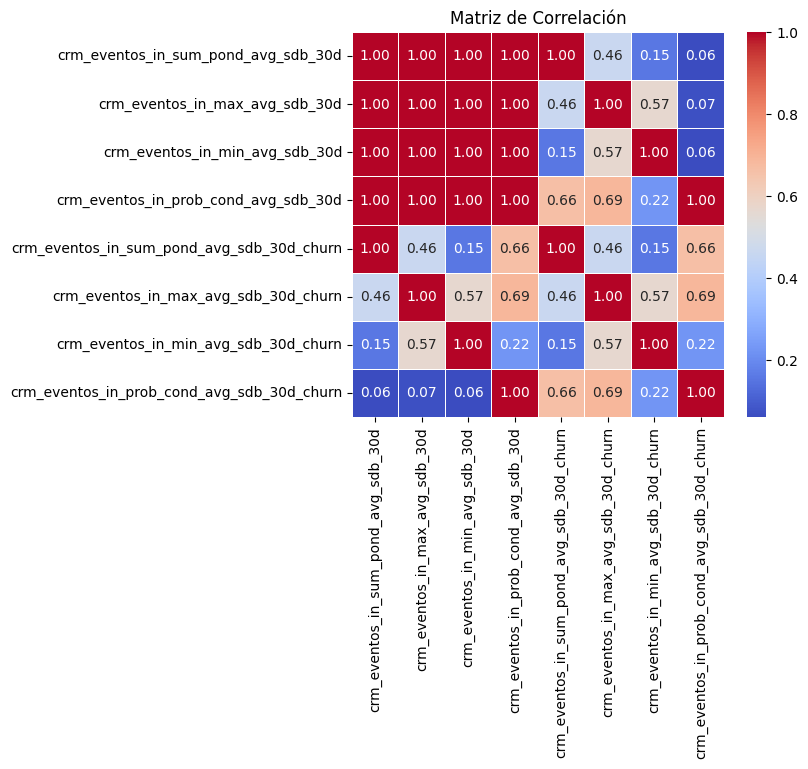

In [14]:
df_merged_corr = df_comun_nptb.join(df_comun_churn, on="id_cliente", how="inner", suffix="_churn")

# esto es para que se quede solo para quedarte solo las que coincidan por fecha (si no, hace un producto cartesiano de fechas)
df_merged_corr = df_merged_corr.filter(df_merged_corr["ndt_data_date"] == df_merged_corr["ndt_data_date_churn"])

df_merged_corr = df_merged_corr.drop(["id_cliente","ndt_data_date", "ndt_data_date_churn"])

# Convertir a Pandas para calcular la matriz de correlación
df_corr = df_merged_corr.to_pandas().corr()

print(f"shape: {df_merged_corr.shape}")

# Graficar la matriz de correlación con matplotlib y seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

De aquí sacamos 2 conclusiones:
- Los valores de las columnas de **churn** se comportan igual que sus coincidentes en la tabla **nptb**
- Dentro de **nptb**, el comportamiento de los valores es el mismo todas con todas, las dropeamos porque no aportan información.
- Nos quedamos entonces con las columnas de **churn** porque, al no estar tan estrechamente correlacionadas, puede enriquecer más al modelo.

### Tabla **Embeddings** de navegación

In [15]:
consulta_tablon_train = f"""
select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.customer_embedding_jzz_202504`
"""
print (consulta_tablon_train)
#bqclient.query(consulta_tablon_train).result()
## Todas las llamadas a analizar TOTAL!!
st=time.time()
df_emb = (
    bqclient.query(consulta_tablon_train)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
print(f"Tiempo de fetch: {timedelta(seconds=time.time() - st)}")
df_emb = pl.from_pandas(df_emb)


select *
from
`mm-bi-catedras-upm.ENERGIA_JAZZTEL.customer_embedding_jzz_202504`

Tiempo de fetch: 0:00:11.934315


In [16]:
print(df_emb.shape)
df_emb.head(10)

(1367905, 101)


id_cliente,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,…,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20341893,0.000807,0.000002,0.000804,-0.000004,-0.001612,-0.000003,0.000009,0.000147,-0.00067,0.001319,-0.000914,-0.000352,-0.000002,0.000034,0.000183,-0.00001,-0.000557,-0.000318,0.00033,-0.000921,-0.000259,-0.000082,0.002184,-0.000044,0.000085,-0.000115,-0.000062,0.000163,0.000122,-0.000059,-0.000004,-0.001707,0.001011,-0.000092,0.000775,0.000108,…,0.000023,0.000056,-0.000101,-0.000777,0.001266,0.002392,-0.003013,-0.000679,0.00038,-0.00017,0.000153,-0.000109,0.000196,0.000622,0.000321,-0.000041,0.000001,0.000057,-0.000044,-0.000325,0.000103,0.000121,-0.000131,-0.000162,0.000004,0.000275,0.000089,0.000173,0.000002,0.000184,0.000022,0.000062,-0.000089,0.000053,-0.000395,0.000324,0.000213
20523418,0.001022,0.000002,-0.000547,0.000001,0.000392,7.5507e-7,-0.000555,0.000095,0.000042,0.000036,-0.000828,-0.00056,0.000081,0.000133,0.000083,0.000008,0.000594,0.001581,0.000869,-0.001038,0.001687,-0.001575,-0.000213,-0.000018,-0.000185,0.000041,-0.000548,0.000006,0.00028,0.000011,-0.000013,0.000124,-0.000126,0.000107,-0.000165,-0.000238,…,-0.00042,-0.000059,-0.000874,0.000308,-0.001249,0.000056,-0.000259,0.000337,-0.000039,0.000005,-0.00002,-0.000032,0.000011,0.000126,-0.00053,-0.000254,0.000022,-0.000014,0.000132,0.000294,0.000312,0.000308,0.000388,0.000398,-0.000092,0.000815,0.00046,0.001582,-0.00006,-0.000029,0.000496,0.000252,-0.000635,0.000147,-0.001844,0.000589,-0.000215
20632741,0.000262,8.9937e-9,0.000807,-0.000005,0.000761,0.000001,0.000642,0.000125,-0.000124,0.000081,0.000149,0.000393,-0.000055,0.000074,0.000044,0.000007,0.0005,-0.000164,-0.000427,0.000025,-0.000178,0.000223,-0.000391,-0.000021,-0.000046,-0.000039,0.000208,0.00011,0.000063,-0.000033,-0.000005,0.000154,-0.000013,-0.000019,0.000389,0.00019,…,-0.000138,0.00005,0.000153,-0.000162,-0.000701,0.000164,-0.000212,-0.000316,0.000026,-0.000098,-0.000009,-0.000033,0.000032,0.000159,0.000006,0.000061,0.000046,0.000002,0.000015,0.000008,0.000202,-0.00006,0.000032,0.000166,0.000016,-0.000347,-0.000141,-0.000381,0.000006,-0.000062,-0.000078,-0.000053,0.000179,0.00001,0.000282,0.000158,-0.000011
21158297,0.000078,4.1639e-8,0.000185,-8.5815e-7,0.000227,-7.8755e-8,-0.000081,0.000063,-5.5621e-8,-0.000049,-0.00002,0.000041,-0.000006,-0.00002,0.000017,0.000002,0.000065,0.000086,-0.000007,-0.000099,0.000134,0.000135,-0.00005,-0.000011,-0.000014,-0.000028,-0.000012,0.000051,-0.000016,-0.00001,-0.000002,0.000084,-0.000059,0.000002,-5.8140e-7,-0.000015,…,0.000022,0.000005,0.000037,0.000022,0.000046,-0.000013,0.000016,-0.000079,-0.000015,-0.000001,0.000024,0.000002,-0.000002,-0.000009,0.000113,-0.000119,-0.00003,0.000002,0.000003,-0.000024,-0.000085,0.000117,-0.000185,0.000082,-0.000004,-0.000155,-0.000044,0.000146,0.000009,0.000043,-0.000026,-0.000006,-0.000004,-8.5602e-8,-0.00004,0.000023,-0.000034
21686383,0.000835,0.000002,-0.000342,6.0380e-7,0.000032,-1.1691e-7,-0.00071,0.000388,0.000078,-0.000071,

### JOIN **NPTB** x **CHURN** x **Embeddings**
Quitando las columnas con información redundante

In [17]:
consulta_join = """
SELECT AS VALUE ARRAY_AGG(t LIMIT 1)[OFFSET(0)]
FROM (
select nptb.* EXCEPT(crm_eventos_in_sum_pond_avg_sdb_30d, crm_eventos_in_prob_cond_avg_sdb_30d, crm_eventos_in_min_avg_sdb_30d, crm_eventos_in_max_avg_sdb_30d),
churn.*, emb.*
from `mm-bi-catedras-upm.ENERGIA_JAZZTEL.nptb_jzz` as nptb
join `mm-bi-catedras-upm.ENERGIA_JAZZTEL.churn_jzz` as churn
on  nptb.uni_id_cliente = churn.customer_id and nptb.ndt_data_date=churn.ndt_data_date
join `mm-bi-catedras-upm.ENERGIA_JAZZTEL.customer_embedding_jzz_202504` as emb
on emb.id_cliente=nptb.uni_id_cliente
) AS t
GROUP BY t.uni_id_cliente;
"""
st=time.time()
df_join = (
    bqclient.query(consulta_join)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        ##create_bqstorage_client=True,
        )
)
print(f"Tiempo de fetch: {timedelta(seconds=time.time() - st)}")
df_join = pl.from_pandas(df_join)
df_join = df_join.drop([
                        "event_timestamp",
                        "created_timestamp"
                       ]+[c for c in df_join.columns if "_field_" in c])


# cambiar las fechas a 'YYYYMM'
df_join = df_join.with_columns(
    pl.col("ndt_data_date").str.slice(0, 6).alias("ndt_data_date")
)


Tiempo de fetch: 0:01:44.395218


In [18]:
print(f"total shape: {df_join.shape}")
df_join.head(10)

total shape: (1251048, 473)


uni_id_cliente,uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,uni_min_cp_importe_fin_linea,uni_min_cp_dias_fin_linea,uni_comp_lineas_oo,…,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100
i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
30580973,1,1,0,"""PYME""",1,5,11,11,85,83,8.77,0.04,17,0.05,0,0,0,57905,0,0,0,0,197,769.890015,0,0.0,0.0,1000,0,1,23,23,0,0.0,-9999,0,…,0.000001,-0.000022,-0.000125,0.00064,0.000402,-0.000125,0.000419,0.000399,-0.000143,-0.000138,-0.000015,-0.00001,-0.000001,0.00008,0.000203,-0.000042,0.000015,0.000017,0.000049,0.000062,0.000123,-0.000106,-0.000112,-0.000046,-0.000011,0.001194,0.000371,-0.000278,-0.000008,-0.000085,0.000438,0.000015,-0.000096,0.000047,-0.000692,0.00005,-0.000451
22117361,1,1,0,"""RESIDENCIAL""",1,1,105,28,165,30,0.0,0.0,-1585,0.0,0,0,0,3102,0,0,0,0,89,684.469971,0,0.0,0.0,1000,0,0,34,139,0,0.0,-2835,1,…,-0.000002,0.000008,0.000005,0.000016,-0.00016,-0.000042,-0.00016,-0.000235,0.000024,-0.000032,-0.000002,0.00001,-0.000025,-0.000093,-0.000023,-0.000064,-0.000006,0.000002,0.000015,0.00006,-0.000064,0.000022,0.000048,0.000084,-9.9970e-7,-0.000053,-0.000005,0.000064,-0.000001,0.000028,0.000043,0.000009,-0.000012,0.000029,-0.000182,0.000143,-0.00008
27649421,1,1,0,"""RESIDENCIAL""",1,2,117,40,117,53,0.0,0.0,-1498,0.0,0,0,0,35452,0,0,0,0,558,883.299988,0,0.0,0.0,1000,0,0,89,89,0,0.0,-2346,1,…,0.000126,0.000056,0.000584,0.000754,0.000052,0.000103,-0.000007,-0.00009,-0.000229,-0.000068,-0.000073,0.000041,-0.000109,-0.000206,-0.00032,-0.00007,0.000057,0.000009,0.000075,0.000124,0.000117,0.000146,0.000064,0.000225,-0.000012,-0.000313,-0.000052,0.000295,0.000018,0.000131,0.000277,0.000031,-3.2105e-7,0.000105,-0.000874,0.000434,-0.000198
29080537,1,1,0,"""RESIDENCIAL""",1,2,98,0,98,38,282.963196,0.93,710,0.97,0,0,0,5268,0,0,0,0,83,206.550003,0,0.0,0.0,1000,0,0,0,0,0,0.0,-710,0,…,-0.000229,0.000008,0.000097,0.000108,-0.000417,-0.000058,-0.000335,-0.00085,-0.000028,-0.000024,0.000031,-0.000046,0.000068,0.000259,0.000247,-0.000521,-0.000135,0.000005,0.000055,-0.000034,-0.00035,-0.000143,9.4255e-7,0.000339,0.000009,-0.000078,-0.000016,-0.000249,0.00004,0.000233,0.000059,-0.000015,0.000073,0.000053,0.000023,0.000335,0.000035
35307358,1,1,0,"""RESIDENCIAL""",1,1,51,10,69,37,0.0,0.0,-1755,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,0,0,0,0.0,-9999,2,…,-0.00006,0.000032,-0.00001,-0.000243,-0.000058,0.000076,0.000146,0.000252,-0.000085,-0.000025,-0.000024,0.000006,-0.000019,-0.00001,-0.000085,-0.000198,-0.000067,-0.000005,-0.000006,0.00008,0.000231,-0.000133,-0.000087,0.000143,-0.000006,0.000045,0.000055,0.000465,0.000043,0.000228,-0.000157,0.000059,-0.000192,-0.000086,0.000331,-0.000075,0.000098
21823208,1,1,0,"""RESIDEN

### Tratamiento de columnas con **valores categóricos**

Vemos los valores categóricos de los campos que son string

In [19]:
columnas_str = [col for col in df_join.columns if df_join[col].dtype == pl.Utf8]
for c in columnas_str:
    print(df_join[c].unique())

shape: (4,)
Series: 'uni_cliente_segmento' [str]
[
	"RESIDENCIAL"
	"PYME"
	"GRAN CUENTA"
	"PROFESIONAL"
]
shape: (14,)
Series: 'axe_tipofamilia' [str]
[
	"Resto"
	"Parejas Jubiladas"
	"Parejas Senior Sin Hijos"
	"Singles"
	"Familiares"
	…
	"Viudos"
	"Jubilado con Hijos"
	null
	"Parejas Jovenes DINKIS"
	"Familia Estandar Senior"
]
shape: (7,)
Series: 'axe_nucleo' [str]
[
	"Single"
	"Monoparental"
	null
	"Pareja"
	"Familiares"
	""
	"Compartidos / Otros/ Mix"
]
shape: (6,)
Series: 'axe_perfilnucleo' [str]
[
	"Joven"
	"Jubilado "
	"Senior"
	null
	""
	"Adulto"
]
shape: (6,)
Series: 'axe_perfilhijos' [str]
[
	"No Emancipados"
	"Sin Hijos"
	null
	""
	"Jovenes"
	"Menores"
]
shape: (4,)
Series: 'ndt_data_date' [str]
[
	"202503"
	"202502"
	"202504"
	"202501"
]
shape: (4,)
Series: 'cliente_segmento' [str]
[
	"PYME"
	"RESIDENCIAL"
	"PROFESIONAL"
	"GRAN CUENTA"
]


Como todas las columnas string son categóricas, aplicamos el **to_dummies** para hacer una columna para cada valor con 0 o 1. (one-hot-encoding) **menos para la fecha**

In [20]:
columnas_str = [col for col in df_join.columns if df_join[col].dtype == pl.Utf8 and col!="ndt_data_date"]

# Reemplazar "" por None en esas columnas
df_join = df_join.with_columns([
    pl.when(pl.col(c) == "").then(None).otherwise(pl.col(c)).alias(c) for c in columnas_str
])

# Ahora aplicar to_dummies
df_join = df_join.to_dummies(columns=columnas_str)

print("nuevo shape:", df_join.shape)
print("tipos de valores del df:", set(df_join.schema.values()))
df_join.head(10)


nuevo shape: (1251048, 504)
tipos de valores del df: {String, Int64, Float64, UInt8}


uni_id_cliente,uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento_GRAN CUENTA,uni_cliente_segmento_PROFESIONAL,uni_cliente_segmento_PYME,uni_cliente_segmento_RESIDENCIAL,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,…,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100
i64,i64,i64,i64,u8,u8,u8,u8,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
30580973,1,1,0,0,0,1,0,1,5,11,11,85,83,8.77,0.04,17,0.05,0,0,0,57905,0,0,0,0,197,769.890015,0,0.0,0.0,1000,0,1,23,23,0,…,0.000001,-0.000022,-0.000125,0.00064,0.000402,-0.000125,0.000419,0.000399,-0.000143,-0.000138,-0.000015,-0.00001,-0.000001,0.00008,0.000203,-0.000042,0.000015,0.000017,0.000049,0.000062,0.000123,-0.000106,-0.000112,-0.000046,-0.000011,0.001194,0.000371,-0.000278,-0.000008,-0.000085,0.000438,0.000015,-0.000096,0.000047,-0.000692,0.00005,-0.000451
22117361,1,1,0,0,0,0,1,1,1,105,28,165,30,0.0,0.0,-1585,0.0,0,0,0,3102,0,0,0,0,89,684.469971,0,0.0,0.0,1000,0,0,34,139,0,…,-0.000002,0.000008,0.000005,0.000016,-0.00016,-0.000042,-0.00016,-0.000235,0.000024,-0.000032,-0.000002,0.00001,-0.000025,-0.000093,-0.000023,-0.000064,-0.000006,0.000002,0.000015,0.00006,-0.000064,0.000022,0.000048,0.000084,-9.9970e-7,-0.000053,-0.000005,0.000064,-0.000001,0.000028,0.000043,0.000009,-0.000012,0.000029,-0.000182,0.000143,-0.00008
27649421,1,1,0,0,0,0,1,1,2,117,40,117,53,0.0,0.0,-1498,0.0,0,0,0,35452,0,0,0,0,558,883.299988,0,0.0,0.0,1000,0,0,89,89,0,…,0.000126,0.000056,0.000584,0.000754,0.000052,0.000103,-0.000007,-0.00009,-0.000229,-0.000068,-0.000073,0.000041,-0.000109,-0.000206,-0.00032,-0.00007,0.000057,0.000009,0.000075,0.000124,0.000117,0.000146,0.000064,0.000225,-0.000012,-0.000313,-0.000052,0.000295,0.000018,0.000131,0.000277,0.000031,-3.2105e-7,0.000105,-0.000874,0.000434,-0.000198
29080537,1,1,0,0,0,0,1,1,2,98,0,98,38,282.963196,0.93,710,0.97,0,0,0,5268,0,0,0,0,83,206.550003,0,0.0,0.0,1000,0,0,0,0,0,…,-0.000229,0.000008,0.000097,0.000108,-0.000417,-0.000058,-0.000335,-0.00085,-0.000028,-0.000024,0.000031,-0.000046,0.000068,0.000259,0.000247,-0.000521,-0.000135,0.000005,0.000055,-0.000034,-0.00035,-0.000143,9.4255e-7,0.000339,0.000009,-0.000078,-0.000016,-0.000249,0.00004,0.000233,0.000059,-0.000015,0.000073,0.000053,0.000023,0.000335,0.000035
35307358,1,1,0,0,0,0,1,1,1,51,10,69,37,0.0,0.0,-1755,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,0,0,0,…,-0.00006,0.000032,-0.00001,-0.000243,-0.000058,0.000076,0.000146,0.000252,-0.000085,-0.000025,-0.000024,0.000006,-0.000019,-0.00001,-0.000085,-0.000198,-0.000067,-0.000005,-0.000006,0.00008,0.000231,-0.000133,-0.000087,0.000143,-0.000006,0.000045,0.000055,0.000465,0.000043,0.000228,-0.000157,0.000059,-0.000192,-0.000086,0.000331,-0.000075,0.000098
21823208,1,1,0,0,0,0,1,1,4,148,39,170,77,0.0,0.0,-1423,0.0,0,0,0,64163,0,0,0,0,63,338.329987,0,0.0,0.

Ahora solo tenemos valores numéricos en el dataframe.

### Incorporación del **target**

In [21]:
# limpiamos el df de altas (electricidad) de campos que no nos interesan
df_altas_electricidad = df_altas_electricidad.drop(["signup_date_altas", "product", "canal","dwh_customer_key"])

In [22]:
df_altas_electricidad = (df_altas_electricidad
                         .with_columns(pl.col("customer_id").cast(pl.Int64) # se pasa la id a int
                                      )
                        )

df_altas_electricidad = df_altas_electricidad.with_columns(
    pl.col("fecha").dt.strftime("%Y%m").alias("fecha") # se pasa la fecha al mismo formato que en la tabla join
)

# ponemos el mismo nombre a las columnas para hacer el join
df_altas_electricidad = df_altas_electricidad.rename({"fecha": "ndt_data_date", "customer_id": "id_cliente"})

df_altas_electricidad.head(5)

ndt_data_date,id_cliente
str,i64
"""202505""",22124727
"""202504""",25911940
"""202503""",25911940
"""202505""",39345505
"""202504""",44698488


In [23]:
df_altas_electricidad.shape

(14825, 2)

In [24]:
# agrega columna target = 0 en df
df_join = df_join.with_columns(pl.lit(0).alias("target"))

# realiza un join para marcar coincidencias
df_join = df_join.join(
    df_altas_electricidad.with_columns(pl.lit(1).alias("marca")),  # añade columna auxiliar
    on=["ndt_data_date", "id_cliente"],
    how="left"
)

# si hay coincidencia (marca == 1), pon target = 1, si no, deja 0
df_join = df_join.with_columns(
    pl.when(pl.col("marca") == 1).then(1).otherwise(pl.col("target")).alias("target")
)

# elimina la columna auxiliar
df_join = df_join.drop("marca")

In [25]:
df_join.head(10)

uni_id_cliente,uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento_GRAN CUENTA,uni_cliente_segmento_PROFESIONAL,uni_cliente_segmento_PYME,uni_cliente_segmento_RESIDENCIAL,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,…,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,target
i64,i64,i64,i64,u8,u8,u8,u8,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
30580973,1,1,0,0,0,1,0,1,5,11,11,85,83,8.77,0.04,17,0.05,0,0,0,57905,0,0,0,0,197,769.890015,0,0.0,0.0,1000,0,1,23,23,0,…,-0.000022,-0.000125,0.00064,0.000402,-0.000125,0.000419,0.000399,-0.000143,-0.000138,-0.000015,-0.00001,-0.000001,0.00008,0.000203,-0.000042,0.000015,0.000017,0.000049,0.000062,0.000123,-0.000106,-0.000112,-0.000046,-0.000011,0.001194,0.000371,-0.000278,-0.000008,-0.000085,0.000438,0.000015,-0.000096,0.000047,-0.000692,0.00005,-0.000451,0
22117361,1,1,0,0,0,0,1,1,1,105,28,165,30,0.0,0.0,-1585,0.0,0,0,0,3102,0,0,0,0,89,684.469971,0,0.0,0.0,1000,0,0,34,139,0,…,0.000008,0.000005,0.000016,-0.00016,-0.000042,-0.00016,-0.000235,0.000024,-0.000032,-0.000002,0.00001,-0.000025,-0.000093,-0.000023,-0.000064,-0.000006,0.000002,0.000015,0.00006,-0.000064,0.000022,0.000048,0.000084,-9.9970e-7,-0.000053,-0.000005,0.000064,-0.000001,0.000028,0.000043,0.000009,-0.000012,0.000029,-0.000182,0.000143,-0.00008,0
27649421,1,1,0,0,0,0,1,1,2,117,40,117,53,0.0,0.0,-1498,0.0,0,0,0,35452,0,0,0,0,558,883.299988,0,0.0,0.0,1000,0,0,89,89,0,…,0.000056,0.000584,0.000754,0.000052,0.000103,-0.000007,-0.00009,-0.000229,-0.000068,-0.000073,0.000041,-0.000109,-0.000206,-0.00032,-0.00007,0.000057,0.000009,0.000075,0.000124,0.000117,0.000146,0.000064,0.000225,-0.000012,-0.000313,-0.000052,0.000295,0.000018,0.000131,0.000277,0.000031,-3.2105e-7,0.000105,-0.000874,0.000434,-0.000198,0
29080537,1,1,0,0,0,0,1,1,2,98,0,98,38,282.963196,0.93,710,0.97,0,0,0,5268,0,0,0,0,83,206.550003,0,0.0,0.0,1000,0,0,0,0,0,…,0.000008,0.000097,0.000108,-0.000417,-0.000058,-0.000335,-0.00085,-0.000028,-0.000024,0.000031,-0.000046,0.000068,0.000259,0.000247,-0.000521,-0.000135,0.000005,0.000055,-0.000034,-0.00035,-0.000143,9.4255e-7,0.000339,0.000009,-0.000078,-0.000016,-0.000249,0.00004,0.000233,0.000059,-0.000015,0.000073,0.000053,0.000023,0.000335,0.000035,0
35307358,1,1,0,0,0,0,1,1,1,51,10,69,37,0.0,0.0,-1755,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,0,0,0,…,0.000032,-0.00001,-0.000243,-0.000058,0.000076,0.000146,0.000252,-0.000085,-0.000025,-0.000024,0.000006,-0.000019,-0.00001,-0.000085,-0.000198,-0.000067,-0.000005,-0.000006,0.00008,0.000231,-0.000133,-0.000087,0.000143,-0.000006,0.000045,0.000055,0.000465,0.000043,0.000228,-0.000157,0.000059,-0.000192,-0.000086,0.000331,-0.000075,0.000098,0
21823208,1,1,0,0,0,0,1,1,4,148,39,170,77,0.0,0.0,-1423,0.0,0,0,0,64163,0,0,0,0,63,338.329987,0,0.0,0.0,1000,0,0,0,0,0,…,-0.000034,-0.00001,0.0

### Creación del **dataframe final** sin duplicados

Se eliminan los duplicados para evitar que aparezcan filas idénticas en los diferentes conjuntos de train, val y test. De esta forma evitamos el overfitting en el entrenamiento.

In [26]:
DF_FINAL = df_join.drop(["customer_id", "uni_id_cliente"]).unique()
#dropeamos el customer_id y uni_id_cliente, ya que son columnas duplicadas con id_cliente

In [27]:
for f in DF_FINAL["ndt_data_date"].unique():
    print(f"Clientes en {f}: {DF_FINAL.filter(DF_FINAL['ndt_data_date']==f).shape[0]}")

Clientes en 202503: 308891
Clientes en 202502: 309702
Clientes en 202504: 331083
Clientes en 202501: 301372


### Visionado del **dataframe final**

In [28]:
DF_FINAL.columns

['uni_cliente_fijo',
 'uni_cliente_movil',
 'uni_cliente_tv',
 'uni_cliente_segmento_GRAN CUENTA',
 'uni_cliente_segmento_PROFESIONAL',
 'uni_cliente_segmento_PYME',
 'uni_cliente_segmento_RESIDENCIAL',
 'uni_lineas_fijo_cliente',
 'uni_lineas_movil_cliente',
 'uni_antig_linea_max',
 'uni_antig_linea_min',
 'uni_antig_cliente',
 'uni_arpu_medio_4m',
 'uni_cp_importe_fin_cli',
 'uni_cp_importe_pctpend_cli',
 'uni_cp_dias_fin_cli',
 'uni_cp_dias_pctpend_cli',
 'uni_dto_meses_fin_cli',
 'uni_dto_valor_cli',
 'uni_dto_porc_cli',
 'uni_mb_consumo_movil_cli',
 'uni_bono_100_mb_cli',
 'uni_bono_adicional_mb_cli',
 'uni_bono_mas_mb_cli',
 'uni_bono_cesion_mb_cli',
 'uni_num_llamadas_dentro_tarifa_cli',
 'uni_minutos_dentro_tarifa_cli',
 'uni_num_llamadas_fuera_tarifa_cli',
 'uni_minutos_fuera_tarifa_cli',
 'uni_importe_fuera_tarifa_cli',
 'uni_dias_consulta_cp',
 'uni_ppfide_dm7',
 'uni_flag_deposito_mb',
 'uni_meses_usdb_movil',
 'uni_meses_1sdb_movil',
 'uni_lineas_fijo_sdb_3m',
 'uni_min_cp

In [29]:
# vistazo final del DF resultante
print("tipos:",set(DF_FINAL.schema.values()))
print("shape:",DF_FINAL.shape)
DF_FINAL.head(10)

tipos: {UInt8, Int64, Int32, Float64, String}
shape: (1251048, 503)


uni_cliente_fijo,uni_cliente_movil,uni_cliente_tv,uni_cliente_segmento_GRAN CUENTA,uni_cliente_segmento_PROFESIONAL,uni_cliente_segmento_PYME,uni_cliente_segmento_RESIDENCIAL,uni_lineas_fijo_cliente,uni_lineas_movil_cliente,uni_antig_linea_max,uni_antig_linea_min,uni_antig_cliente,uni_arpu_medio_4m,uni_cp_importe_fin_cli,uni_cp_importe_pctpend_cli,uni_cp_dias_fin_cli,uni_cp_dias_pctpend_cli,uni_dto_meses_fin_cli,uni_dto_valor_cli,uni_dto_porc_cli,uni_mb_consumo_movil_cli,uni_bono_100_mb_cli,uni_bono_adicional_mb_cli,uni_bono_mas_mb_cli,uni_bono_cesion_mb_cli,uni_num_llamadas_dentro_tarifa_cli,uni_minutos_dentro_tarifa_cli,uni_num_llamadas_fuera_tarifa_cli,uni_minutos_fuera_tarifa_cli,uni_importe_fuera_tarifa_cli,uni_dias_consulta_cp,uni_ppfide_dm7,uni_flag_deposito_mb,uni_meses_usdb_movil,uni_meses_1sdb_movil,uni_lineas_fijo_sdb_3m,uni_min_cp_importe_fin_linea,…,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,target
i64,i64,i64,u8,u8,u8,u8,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
1,1,0,0,0,0,1,1,2,116,39,116,56,961.443604,0.72,554,0.76,0,0,0,19403,0,0,0,0,199,919.659973,0,0.0,0.0,1000,0,0,0,0,0,0.0,…,0.000008,0.000001,-0.000015,-0.00001,-0.000006,0.000019,-0.000019,8.5391e-7,-5.2527e-7,-0.000001,-0.000005,0.000008,0.000038,-0.000009,-0.000001,0.000001,-5.3281e-8,0.000002,0.000012,-0.000003,0.000003,7.4982e-7,0.000002,-5.0966e-7,-0.000006,-0.000001,0.000009,-2.1978e-7,-8.9080e-7,0.000004,-3.0132e-9,3.8320e-7,-0.000001,-0.000016,0.000008,0.000001,0
1,1,0,0,0,0,1,1,1,82,28,157,36,0.0,0.0,-242,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,118,118,0,0.0,…,-0.000028,-0.000093,0.000637,-0.000249,0.000646,0.000667,0.001344,-0.001009,0.00006,-0.000005,0.000026,-0.000109,-0.000212,0.00013,-0.000276,-0.000181,-7.4635e-9,-0.000116,0.00025,0.000692,0.000666,-0.000013,-0.002333,0.000049,-0.000155,-0.000254,-0.000181,-0.000049,-0.000475,-0.000204,-0.000032,0.000009,0.000022,-0.000102,0.000065,0.000199,0
1,1,0,0,0,0,1,1,1,45,38,45,39,352.740814,0.45,482,0.66,0,0,0,2476,0,0,0,0,11,8.25,0,0.0,0.0,1000,0,0,0,0,0,49.549999,…,-0.000033,0.000069,0.000182,0.000117,-0.000322,-0.000512,-0.001135,-0.001253,0.000101,0.000014,0.000014,-0.000048,-0.000109,0.000257,-0.00022,-0.000039,-0.000001,-0.00002,0.000007,-0.000668,0.000765,0.000639,-0.000936,0.000067,0.000084,-0.00008,0.000073,-0.000052,-0.000712,-0.000427,0.000008,-0.000145,-0.000047,0.000281,0.000181,0.000072,0
1,1,0,0,0,0,1,1,1,159,33,210,33,0.0,0.0,-1415,0.0,0,0,0,0,0,0,0,0,21,73.580002,0,0.0,0.0,1000,0,0,0,0,0,0.0,…,-0.000014,-0.000092,-0.000093,-0.000059,-0.000098,0.000019,0.000261,-0.000005,0.000003,0.000029,-0.000027,0.000046,0.000163,0.000162,0.000024,0.000001,-0.000004,-0.000005,-0.00006,0.000248,-0.000008,-0.000027,0.000023,-0.000003,-0.000016,0.000009,0.000106,0.000004,0.000029,-0.000085,0.000022,-0.000036,-0.000018,0.000041,-0.000079,0.000169,0
1,0,0,0,0,0,1,1,0,20,20,20,24,0.0,0.0,-261,0.0,0,0,0,0,-9999,-9999,-9999,0,0,0.0,0,0.0,0.0,1000,0,-1,0,0,0,0.0,…,-0.00003,-0.000406,0.000505,0.000189,-0.000025,0.000219,-0.000137,-0.000192,-0.000137,6.9422e-7,0.000007,0.000044,-0.000157,0.000312,0.000099,0.000089,0.000019,0.000076,0.000237,0.000083,-0.000164,-0.000095,0.000332,-0.000002,-0.000327,-0.000098,-0.000945,-0.000014,0.000353,-0.000089,-0.000036,0.000078,-0.000058,0.000709,-0.000076,0.000137,0
1,1,0,0,0,0,1,1,1,73,39,104,33,0.0,0.0,-726,0.0,0,0,0,9622,0,0,0,0,0,0.0,0,0.0,0.0,1000,0,0,96,96,0,0.0,…,0.000072,0.000327,0.0000